In [1]:
# Make code toggle-able for easier review.
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<i>The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a></i>.''')

In [102]:
import math
from scipy.stats import normaltest
from scipy import stats
from sklearn import linear_model
from sklearn import neighbors
from sklearn.model_selection import cross_val_score


import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std


import numpy as np
import pandas as pd
pd.options.display.max_columns = None

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline

import seaborn as sns

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [76]:
# Read the training data
root_folder = '/Users/guest/Dropbox/Education/Thinkful/Unit 3 - Deeper into supervised learning/Lesson 1 - Similarity models/U3L1P4 - Challenge - model comparison/housing_prices_data/'

training_set_dir = root_folder + 'train.csv'
test_set_dir = root_folder + 'test.csv'
data_desc = root_folder + 'data_description.txt'

training_data = pd.read_csv(training_set_dir)
test_data = pd.read_csv(test_set_dir)

___Unit 3 / Lesson 1 / Project 4___
# <font size =40>Challenge: Model Comparison</size>

In [4]:
###### Functions for visualizing lots of distributions at once

# Define a function that splits a list into n-length chunks
def chunks(l, n):
    # For item i in a range that is a length of l,
    for i in range(0, len(l), n):
        # Create an index range for l of n items:
        yield l[i:i+n]
        

# Define a histogram plotting function that utilizes the chunk function to yield n-length rows of histograms
def plot_hists(frame, vs, width, colors=list(sns.color_palette("Set3").as_hex())):
    variables_chunked = chunks(vs, width) # Chunk the list of variables
    
    my_colors = colors
    
    # Create a chart for each chunk
    for chunk in variables_chunked:
        fig, axes = plt.subplots(1, len(chunk), figsize=(12,2))
        fig.tight_layout()
        
        # Plot the variables in each chunk's charts
        for var in chunk:
            idx = chunk.index(var)
            frame.hist(var, ax=axes[idx], xrot=90, alpha=0.9, color=my_colors[idx])
        
        plt.show()
        
        
# Define a bar chart plotting function that utilizes the chunk function to yield n-length rows of bar charts
def plot_bars(frame, vs, width):
    variables_chunked = chunks(vs, width) # Chunk the list of variables
    
    # Create a chart for each chunk
    for chunk in variables_chunked:
        fig, axes = plt.subplots(1, len(chunk), figsize=(12,2))
        fig.tight_layout()
        
        # Plot the variables in each chunk's charts
        for var in chunk:
            idx = chunk.index(var)
            frame[var].value_counts().head(20).plot.bar(ax=axes[idx], title=var)
            
            
        plt.show()

In [5]:
###### Function for visualizing the impact of winsorization on a distribution

# Define a function to compare different winsorization cutoffs
def winsorize_test(dataframe, # Dataset
                   variable, # Variable of interest
                   right_tail, # Test winsorization at the upper end of the distribution (True/False)
                   left_tail, # Test winsorization at the lower end of the distribution (True/False)
                   lower_check_limit=0.01, # The smallest percentile cutoff to check
                   upper_check_limit=0.06, # The largest percentile cutoff to check
                   colors="Set3", # Seaborn color palette for figure aesthetics
                   x_formatter = '${x:,.0f}'
                  ):     
    
    # Create a dataframe to store the transformed variables
    test_df = pd.DataFrame() 
    test_df['0.00'] = dataframe[variable] # Variable of interest without winsorization
    
    # Create a range of percentile cutoffs to check
    test_cutoffs = np.arange(lower_check_limit, upper_check_limit, 0.01) 
 
    # Interpret which tails to test for each cutoff in the range
    for limit in test_cutoffs:
        if left_tail == True:
            low_bound = limit
        else:
            low_bound = 0   
        if right_tail == True:
            high_bound = limit
        else:
            high_bound = 0  
            
        winsor_limits = (low_bound, high_bound) # Set the limits 
        
        # Identify whether a one or two-tailed winsorization is being applied
        if right_tail == True & left_tail == True:
            tails = 'two-tailed'
        else:
            tails = 'one-tailed'
        
        # Winsorize and store
        test_df[str(limit)] = stats.mstats.winsorize(dataframe[variable], limits=winsor_limits)
        
        
    # VISUALIZATIONS

    # Boxplot
    plt.figure(figsize=(14.5,2))
    box_title = 'Distribution of {} given various {} winsorization cutoffs'.format(variable, tails)
    ax = sns.boxplot(data=test_df, 
                     orient="h", 
                     palette=colors).set_title(box_title)
    
    ax = plt.axes()
    ax.xaxis.set_major_formatter(mtick.StrMethodFormatter(x_formatter))

    plt.show()

    # Histograms
    hex_colors = list(sns.color_palette(colors).as_hex()) # Convert the seaborn palette to a list of hex values
    plot_hists(test_df, list(test_df), 6, hex_colors)
    plt.show()

In [192]:
###### Function for visualizing and quantifying the impact of mathematical transformations on features

def transformation_test(data, 
                        variable, 
                        alpha=0.05, 
                        colors=(['blue']*7),
                        output_all=True):    
    
    # Define transformation functions when necessary and store them in a dictionary.
    def untransformed(x):return x
    def square(x):return x**2
    def cube(x):return x**3
    def recip(x):return 1/x

    tests = {'no_transformation':untransformed,
             'squared_data':square,
             'cubed_data':cube,
             'square_root':np.sqrt,
             'cube_root':np.cbrt,
             'log':np.log,
             'reciprocal':recip}
    
    # Transform the variables & store outputs
    test_df = pd.DataFrame(columns=list(tests)) # Create a dataframe to store the transformed variables in
    
    # Create a dictionary to store test outputs
    output_dict = {'transformation':list(tests.keys()),
                   'test_statistic':[],
                   'p_value':[]
                  }
        
    for element in tests: # Iterate through the dictionary of transformation functions
        
        # Apply transformation to target variable & store it in the dataframe
        test_df[element] = data[variable].apply(lambda x: tests[element](x)) 
        
        # Perform the statistical test & generate a summary readout
        stat, p = normaltest(test_df[element])
        output_dict['test_statistic'].append(round(stat,2))
        output_dict['p_value'].append(round(p,4))
        
    def p_check(p, alpha):
        if p < alpha:
            return 0
        else:
            return 1
        
    output_df = pd.DataFrame(output_dict, columns = ['transformation', 'test_statistic', 'p_value'])
    output_df['normal'] = np.where(output_df['p_value']> alpha, True, False)
            
    
    # Plot histograms of the transformations
    plot_hists(test_df,
               list(tests),
               width=7,
               colors=(colors))
    plt.show
    
    # Print statistical readouts
    if output_all == False:
        if output_df.loc[output_df['normal'] == True].shape[0] > 0:
            print('Returning transformations that made the data normal.\n')
            return output_df.loc[output_df['normal'] == True]
        else:
            nearest_match = output_df.loc[output_df['test_statistic'] == output_df['test_statistic'].min()]
            
            print('None of the applied transformations made the distribution normal! Returning nearest match.\n')
            return nearest_match
            
    else:
        return output_df

In [196]:
###### Function for recoding variables

def convert(check_dataframe, # Original dataframe
            output_dataframe, # Dataframe to output recoded values to
            conversion_dict, # Codebook dictionary
            recode_name='recoded' # String to append to recoded column name
           ):
    
    converted_list = []
    for var in list(check_dataframe):
        if set(check_dataframe[var]).issubset(set(conversion_dict.keys())): 
            
            recoded_variable_name = var.lower() + '_' + recode_name
            converted_list.append(recoded_variable_name)
            
            output_dataframe[recoded_variable_name] = check_dataframe[var].apply(lambda x: conversion_dict[x])
            
        else: pass
    
    return converted_list

# 1. Feature Engineering

## (a) Target Variable – Sale Price

In [8]:
# Create a dataframe to store features in
features_df = pd.DataFrame()

In [9]:
# Define colors for sale price that'll help visually distinguish it from other variables
untransformed_target_color = sns.color_palette("Set3").as_hex()[1]
transformed_target_color = sns.color_palette("Set3").as_hex()[5]
complementary_target_color = sns.color_palette("Set3").as_hex()[2]

### _checking sale price for outliers & previewing winsorized distributions_

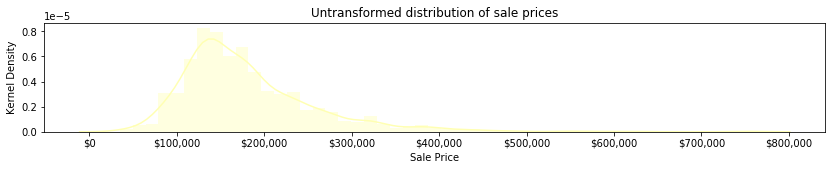

In [10]:
plt.figure(figsize=(14,2))

fig = sns.distplot(training_data['SalePrice'], 
                   kde=True,
                   color=untransformed_target_color).set_title('Untransformed distribution of sale prices')

plt.xlabel("Sale Price")
plt.ylabel("Kernel Density")

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

ax = plt.axes()
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

plt.show()

The histogram above and the boxplot below _(labeled '0.00' because that's where its percentile is cut by winsorization)_ indicate a pretty condensed first two quartiles and an exponential dropoff in frequency at around \$160,000. This range of prices seems reasonable given that the dataset concerns housing in Iowa, and the distribution illustrates about what I'd expect in terms of costs at the high end – a few homeowners are very ___very___ wealthy, a few more are just _very_ wealthy, and most are neither.

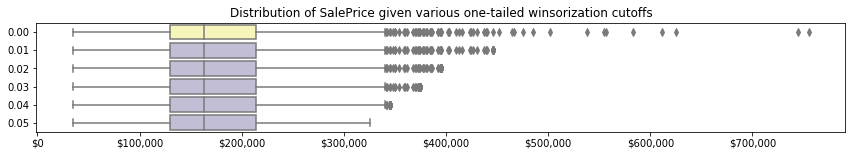

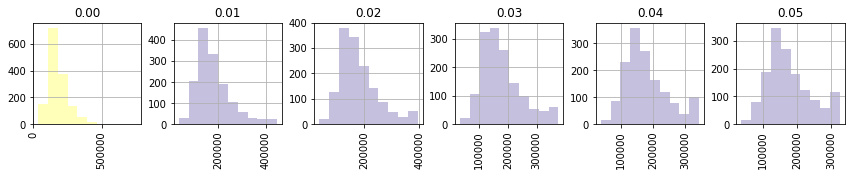

In [11]:
winsorize_test(training_data,
               'SalePrice', 
               right_tail=True, 
               left_tail=False, 
               colors=([untransformed_target_color] + ([complementary_target_color] * 5)),
               x_formatter = '${x:,.0f}')

I'd like to deal with these outliers while maintaining the integrity of the data as much as possible. Based on the histograms, a winsorization cutoff of 0.03 seems to eliminate the worst of them without trending too much towards artificial bimodality. It still doesn't play very well with the exponential dropoff, so I'm going to try some other transformations.

### _testing mathematical transformations of sale price for normality_

Let's see if any mathematical transformations make the data more normal than winsorizing did.

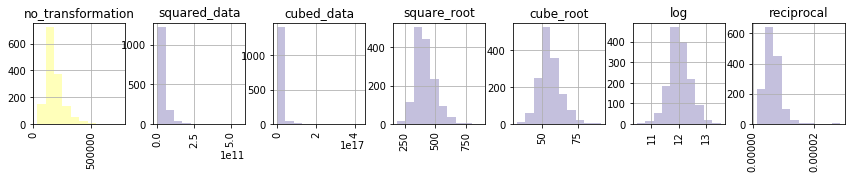

      transformation  test_statistic  p_value  normal
0  no_transformation          610.84      0.0   False
1       squared_data         1512.59      0.0   False
2         cubed_data         2332.37      0.0   False
3        square_root          228.81      0.0   False
4          cube_root          131.81      0.0   False
5                log           25.51      0.0   False
6         reciprocal          750.29      0.0   False


In [12]:
print(transformation_test(data=training_data,
                          variable='SalePrice',
                          alpha=0.05,
                          colors=([untransformed_target_color] + ([complementary_target_color] * 6))))

None of these transformations make the variable totally normal, but log is a pretty good approximation relative to both winsorization and the other transformations I've tried here. I'm going to move forward with logged sale price as my outcome feature, and I'll come back later to tool around if I need to.

### _transformed sale price feature for use in modeling_

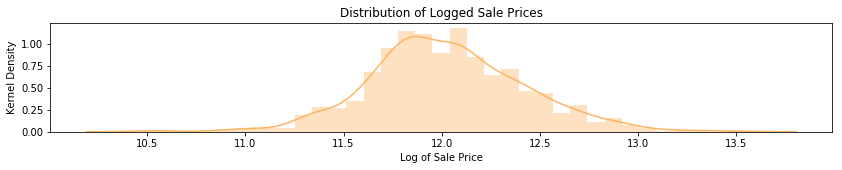

In [13]:
# Add logged sale price to the dataframe of features
features_df['sale_price_log'] = training_data['SalePrice'].apply(lambda x: np.log(x)) 

# Plot the distribution of sale price
plt.figure(figsize=(14,2))
fig = sns.distplot(features_df['sale_price_log'], 
                   kde=True, 
                   color=transformed_target_color).set_title('Distribution of Logged Sale Prices')

plt.xlabel("Log of Sale Price")
plt.ylabel("Kernel Density")
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax = plt.axes()
plt.show()

Not too bad!

## (b) Potential Features

Here's a .txt overview of all the variables included in this dataset. I'm going to narrow them down, so I'm only including it here as a reference.

In [14]:
print(open(data_desc,'r').read())

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

__I think that the following variables are likely to influence sale price:__
* overall finished square footage (_GrLivArea + TotalBsmtSF_)
* above-ground square footage (_GrLivArea_)
* house style – one story, two story, etc. (_HouseStyle_)
* total bedrooms (_BedroomAbvGr_) 
* overall quality (_OverallQual_)
* overall condition (_OverallCond_)
* the various quality & condition evaluations (_"ExterQual" etc._)

## (b1) _Continuous Variables_

### _distributions of continuous variables_

In [15]:
# Color codes for continuous variables
cont_color = sns.color_palette("Blues").as_hex()[5]
cont_complement = '#ff6600'

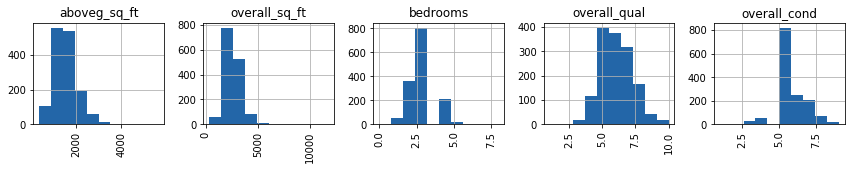

In [16]:
# Create the total square foot feature
training_data['overall_sq_ft'] = training_data['GrLivArea'] + training_data['TotalBsmtSF']

# Define the new variables
vars_dict = {'GrLivArea':'aboveg_sq_ft',
             'overall_sq_ft':'overall_sq_ft',
             'BedroomAbvGr':'bedrooms',
             'OverallQual':'overall_qual',
             'OverallCond':'overall_cond'}

# Check for nulls
for var in list(vars_dict.keys()):
    if training_data[var].isnull().sum() > 0:
        print('WARNING! Nulls in {}: {}'.format(var,str(training_data[var].isnull().sum())))
    else:
        features_df[vars_dict[var]] = training_data[var]
        
plot_hists(features_df, list(vars_dict.values()),5, [cont_color]*5)

### _correlations between continuous variables_

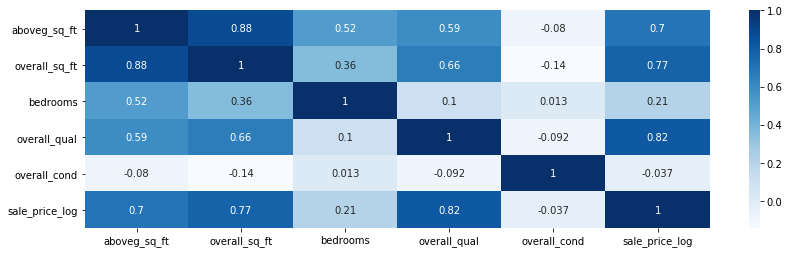

In [17]:
plt.figure(figsize=(14,4))
sns.heatmap(features_df[list(vars_dict.values()) + ['sale_price_log']].corr(), cmap="Blues", annot=True)
plt.show()

* __Overall quality__ is the strongest strong correlate of sale price. I'll definitely give it a try in my model.


* __Overall square footage__ is a mixed bag – it's more correlated with sale price than __above ground square footage__, but I'm able to get above ground square footage normal with a log transformation, and I'm _not_ able to get overall square footage normal (see below). looking pretty good too – it's more correlated with sale price than above ground square footage, which makes sense. It's also correlated with overall quality, which is something to watch out for. 


* __Bedrooms__ and __overall condition__ aren't particularly appealing.

### _transforming the continuous variables_

###### overall square footage

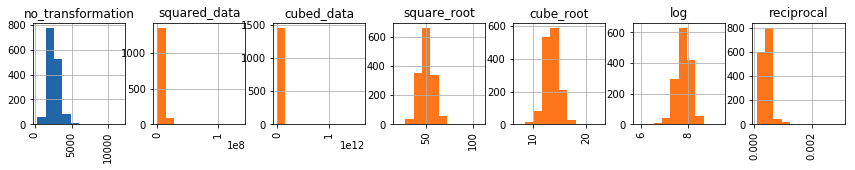

None of the applied transformations made the distribution normal! Returning nearest match.

  transformation  test_statistic  p_value  normal
4      cube_root           83.28      0.0   False


In [18]:
print(transformation_test(data=features_df,
                          variable='overall_sq_ft',
                          alpha=0.05,
                          colors=([cont_color] + ([cont_complement] * 6)),
                          output_all=False))

###### above ground square footage

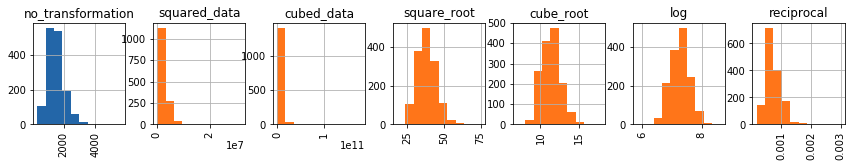

Returning transformations that made the data normal.

  transformation  test_statistic  p_value  normal
5            log            4.08   0.1298    True


In [19]:
print(transformation_test(data=features_df,
                          variable='aboveg_sq_ft',
                          alpha=0.05,
                          colors=([cont_color] + ([cont_complement] * 6)),
                          output_all=False))

###### overall quality

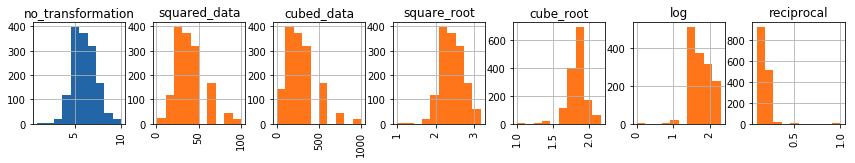

None of the applied transformations made the distribution normal! Returning nearest match.

      transformation  test_statistic  p_value  normal
0  no_transformation            11.9   0.0026   False


In [20]:
print(transformation_test(data=features_df,
                          variable='overall_qual',
                          alpha=0.05,
                          colors=([cont_color] + ([cont_complement] * 6)),
                          output_all=False))

### _selecting features from the continuous variables_

__Overall square footage__, __above ground square footage__, and __overall quality__ are the only variables I've examined here that have a strong relationship with sale price. Between the two square footage variables, I'd rather work with __above ground square footage__ because I was able to normalize it with a log transformation.

__Overall quality__ has a strong positive correlation with sale price. I wasn't able to normalize it, but the untransformed variable is pretty close to normal.<br>
I'm going to try to use it as a feature in my model.
<br><br><br>
_<u>features so far:</u>_

In [21]:
features_df['aboveg_sq_ft_log'] = features_df['aboveg_sq_ft'].apply(lambda x: np.log(x)) 

# Drop all the variables examined above except for overall quality & logged above-ground square footage
drop_continuous = list(vars_dict.values())
drop_continuous.remove('overall_qual')

features_df.drop(drop_continuous, axis=1, inplace=True)
print(list(features_df))

['sale_price_log', 'overall_qual', 'aboveg_sq_ft_log']


## (b2) _Five Point Quality Scaled Variables_

In [22]:
five_pt_color = sns.color_palette("Purples").as_hex()[5]
five_pt_complement = '#94cc3b'

Many of the rating variables that I'm interested in in this dataset are coded as strings on a 5 point scale from "Poor" to "Excellent". I'm going to convert variables coded this way to a 1-5 scale. Some variables scaled this way include NA, indicating the absence of the item rated by the scale. In the documentation, some of these are coded as 'NA' for not present, but in the actual data 'NA' appears to be coded as nan (see below). Because nan appears to indicate the absence of a feature from the house, I'm going to code it as 0. 

In [23]:
five_pt_conversions = {'Ex':5,
                       'Gd':4,
                       'TA':3,
                       'Fa':2,
                       'Po':1,
                       'NA':0,
                       np.nan:0}

for variable in list(training_data):
    if set(training_data[variable]).issubset(set(five_pt_conversions.keys())):
        null_count = training_data[variable].isnull().sum()   
        print('{} includes {}; has {} null values'.format(variable,str(set(training_data[variable])),null_count))

ExterQual includes {'TA', 'Fa', 'Ex', 'Gd'}; has 0 null values
ExterCond includes {'Ex', 'Fa', 'Po', 'Gd', 'TA'}; has 0 null values
BsmtQual includes {nan, 'Ex', 'Fa', 'Gd', 'TA'}; has 37 null values
BsmtCond includes {nan, 'Fa', 'Po', 'Gd', 'TA'}; has 37 null values
HeatingQC includes {'Ex', 'Fa', 'Po', 'Gd', 'TA'}; has 0 null values
KitchenQual includes {'TA', 'Fa', 'Ex', 'Gd'}; has 0 null values
FireplaceQu includes {nan, 'Ex', 'Fa', 'Po', 'Gd', 'TA'}; has 690 null values
GarageQual includes {nan, 'Ex', 'Fa', 'Po', 'Gd', 'TA'}; has 81 null values
GarageCond includes {nan, 'Ex', 'Fa', 'Po', 'Gd', 'TA'}; has 81 null values
PoolQC includes {nan, 'Fa', 'Gd', 'Ex'}; has 1453 null values


### _distributions of quality scale variables_

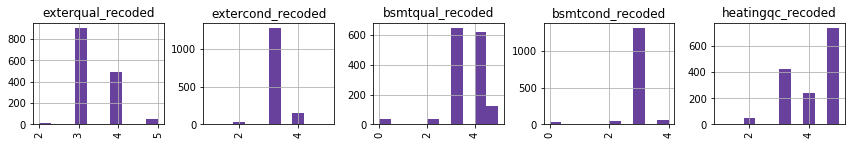

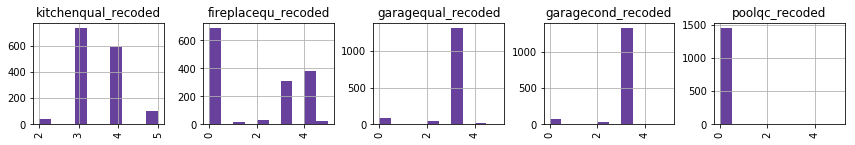

In [24]:
five_pt_variables = convert(check_dataframe=training_data, 
                            output_dataframe=features_df, 
                            conversion_dict=five_pt_conversions)

plot_hists(frame=features_df, 
           vs=five_pt_variables, 
           width=5,
           colors=([five_pt_color] * len(five_pt_variables)))

### _correlations between five point variables_

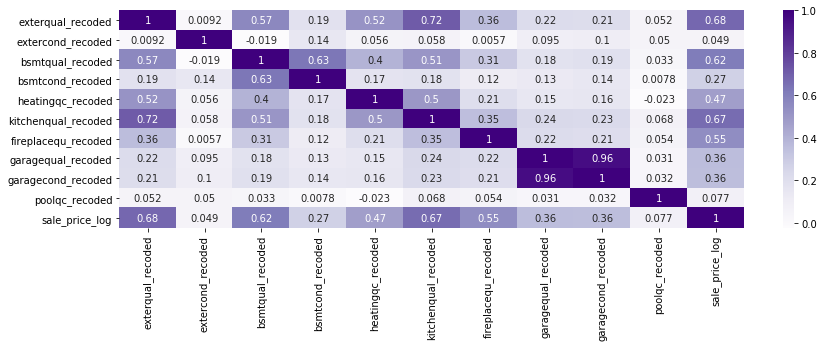

In [25]:
plt.figure(figsize=(14,4))
sns.heatmap(features_df[five_pt_variables + ['sale_price_log']].corr(), cmap='Purples', annot=True)
plt.show()

I'm seeing interesting correlations between __sale price__,  __external quality__, and __kitchen quality__. I have a hunch that external quality will be a better predictor than kitchen quality, and I want to avoid correlated features as much as possible. I'm going to move forward with exterqual as a feature, and ignore the rest for my first iteration.
<br><br><br>
_<u>features so far:</u>_

In [26]:
# Drop all the variables examined above except for external condition
drop_five_points = five_pt_variables
drop_five_points.remove('exterqual_recoded')
features_df.drop(drop_five_points, axis=1, inplace=True)
print(list(features_df))

['sale_price_log', 'overall_qual', 'aboveg_sq_ft_log', 'exterqual_recoded']


### _transforming external quality_

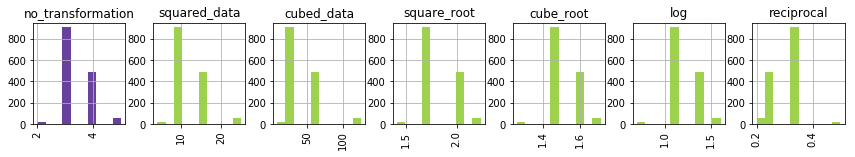

      transformation  test_statistic  p_value  normal
0  no_transformation          130.14      0.0   False
1       squared_data          248.37      0.0   False
2         cubed_data          415.97      0.0   False
3        square_root           89.99      0.0   False
4          cube_root           76.75      0.0   False
5                log           48.99      0.0   False
6         reciprocal           40.60      0.0   False


In [27]:
print(transformation_test(data=features_df,
                          variable='exterqual_recoded',
                          alpha=0.05,
                          colors=([five_pt_color] + ([five_pt_complement] * 6))))

None of these distributions are normal, which makes sense given that external quality is on such a small scale. I'm going to test my models with both the reciprocal transformation and dummies.
<br><br><br>
_<u>features so far:</u>_

In [28]:
# Add the dummy variables for external quality
features_df['exterqual_recoded_for_dummies'] = features_df['exterqual_recoded']
features_df = pd.get_dummies(features_df.copy(), columns=['exterqual_recoded_for_dummies'], prefix='exterqual', prefix_sep='_')
print(list(features_df))

['sale_price_log', 'overall_qual', 'aboveg_sq_ft_log', 'exterqual_recoded', 'exterqual_2', 'exterqual_3', 'exterqual_4', 'exterqual_5']


## (c) Review Features

### _correlation matrix_

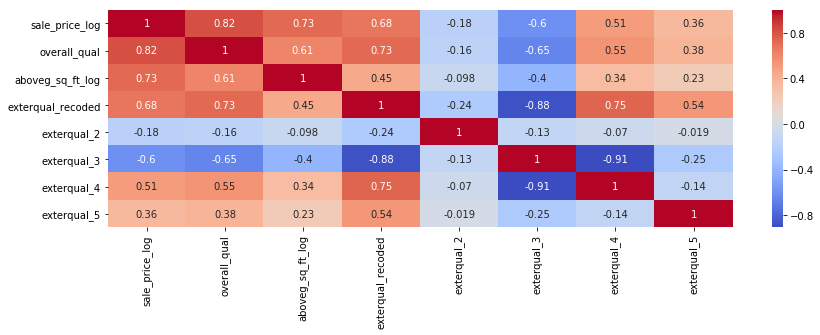

In [29]:
plt.figure(figsize=(14,4))
sns.heatmap(features_df.corr(), cmap="coolwarm", annot=True)
plt.show()

### _checking for outliers_
I know that I'm going to move forward with overall quality and aboveg_sq_ft as variables – let's check them for outliers.

__Overall Quality__

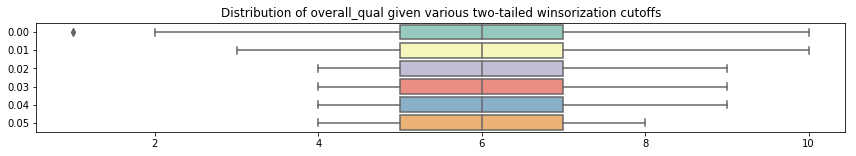

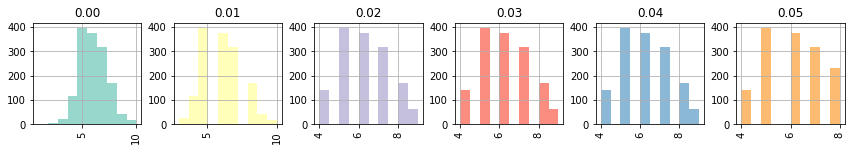

In [34]:
winsorize_test(features_df, # Dataset
                   'overall_qual', # Variable of interest
                   right_tail=True, # Test winsorization at the upper end of the distribution (True/False)
                   left_tail=True, # Test winsorization at the lower end of the distribution (True/False)
                   lower_check_limit=0.01, # The smallest percentile cutoff to check
                   upper_check_limit=0.06, # The largest percentile cutoff to check
                   colors="Set3", # Seaborn color palette for figure aesthetics
                   x_formatter = '{x:,.0f}'
                  )

__Above-Ground Square Footage__

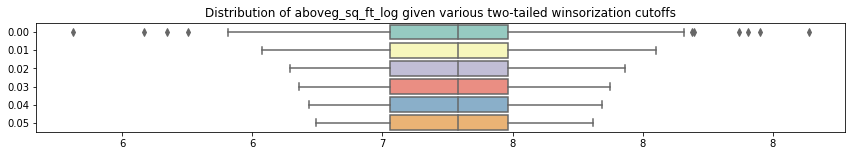

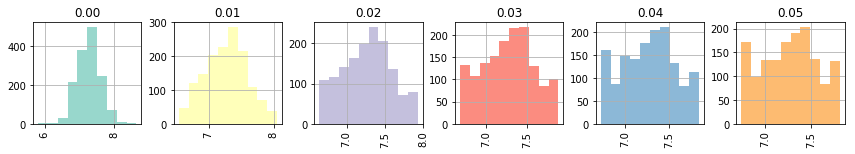

In [35]:
winsorize_test(features_df, # Dataset
                   'aboveg_sq_ft_log', # Variable of interest
                   right_tail=True, # Test winsorization at the upper end of the distribution (True/False)
                   left_tail=True, # Test winsorization at the lower end of the distribution (True/False)
                   lower_check_limit=0.01, # The smallest percentile cutoff to check
                   upper_check_limit=0.06, # The largest percentile cutoff to check
                   colors="Set3", # Seaborn color palette for figure aesthetics
                   x_formatter = '{x:,.0f}'
                  )

Looks like winsorizing with a cutoff of 0.01 will do the trick.
<br><br><br>
_<u>features so far:</u>_

In [41]:
features_df['overall_qual_wins'] = stats.mstats.winsorize(features_df['overall_qual'], limits=(0.01,0.01))
features_df['aboveg_sq_ft_log_wins'] = stats.mstats.winsorize(features_df['aboveg_sq_ft_log'], limits=(0.01,0.01))
print(list(features_df))

['sale_price_log', 'overall_qual', 'aboveg_sq_ft_log', 'exterqual_recoded', 'exterqual_2', 'exterqual_3', 'exterqual_4', 'exterqual_5', 'overall_qual_wins', 'aboveg_sq_ft_log_wins']


In [194]:
###### Function for ensuring the assumptions of OLS regression are met by a model

def ols_assumption_check(model,target):
    # Extract predicted values.
    predicted = model.predict(X).ravel()
    actual = target

    # Calculate the error, also called the residual.
    residual = actual - predicted

    # Plot the charts
    plt.figure(figsize=(14,6))

    # Residual distribution
    plt.subplot(221)
    plt.hist(residual)
    plt.title('Distriution of residual counts given all transformations')
    plt.xlabel('Residual')
    plt.ylabel('Count')

    # Test homosedasticity
    plt.subplot(222)
    ax2 = plt.scatter(predicted, residual)
    plt.xlabel('Predicted')
    plt.ylabel('Residual')
    plt.axhline(y=0)
    plt.title('Residual vs. Predicted')
    plt.show()

In [195]:
###### Function for cross-validating OLS regression models

# Define functions that allow for easy switching between formula format and list format
def list_from_formula(formula): return formula.split()[2].split('+')

def formula_from_list(dependent,independents):
    output_formula = dependent + ' ~ '
    for variable in independents:
        if variable == independents[0]:
            output_formula += variable
        else:
            output_formula += ('+' + variable)
    return output_formula

# Define the cross_validation function
def ols_cross_validation(dataframe, k, dv, ivs):

    frames = np.array_split(dataframe, k)     # Split frame into K folds  
        
    # Create dictionary to house cross validation results
    cv_dict = {'fold':[],
               'n':[],
               'R2':[]}
    for var in ivs: cv_dict[(var + '_p')] = []
        
    # Iterate through frames and record results
    label = 0     # Set fold label for easier reading

    for f in frames:
        
        # Create model from fold
        fold_formula = formula_from_list(dv,ivs)
        fold_model = smf.ols(formula=fold_formula, data=f).fit()

        # Record fold information
        label += 1 # Set fold label
        cv_dict['fold'].append(label) # Record fold label
        cv_dict['n'].append(f.shape[0]) # Record fold size
        
        # Record R squared for model
        cv_dict['R2'].append(round(float(fold_model.rsquared),3))

        # Record p values for independent variables
        pvalue_idx = 1 # set at one to skip intercept
        
        for var in fold_model.pvalues.index[1:]:
            cv_dict[(str(var) + '_p')].append(round(fold_model.pvalues[pvalue_idx],6))
            pvalue_idx += 1
        
    
    # Convert dictionary to dataframe
    summary_frame = pd.DataFrame(cv_dict, columns=list(cv_dict.keys())).set_index('fold')

    return summary_frame

<hr>
# 2. Regression Models

__I've tinkered a little bit, and the final model I'm going to be using for this project is:__<br>
$ log(Sale Price) = Overall Quality + log(Above-ground Square Footage)$

External quality wasn't particularly predictive no matter how I spun it.

In [100]:
model_Y = 'sale_price_log'
model_X = ['overall_qual_wins','aboveg_sq_ft_log_wins']

regression_frame = features_df[[model_Y] + model_X].copy()

regression_frame.head()

,sale_price_log,overall_qual_wins,aboveg_sq_ft_log_wins
0,12.247694,7,7.444249
1,12.109011,6,7.140453
2,12.317167,7,7.487734
3,11.849398,7,7.448334
4,12.429216,8,7.695303


## (a) OLS Regression

### _instantiate the model & check assumptions_


Coefficients: 
 [ 0.17205327  0.45805376]

Intercept: 
 7.64468484626

R-squared:
0.75085613251


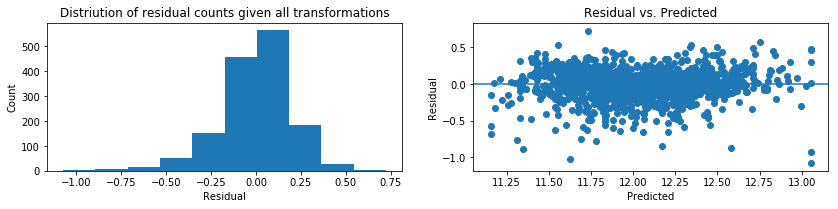

In [165]:
ols_regr = linear_model.LinearRegression()
Y = regression_frame[model_Y]
X = regression_frame[model_X]
ols_regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', ols_regr.coef_)
print('\nIntercept: \n', ols_regr.intercept_)
print('\nR-squared:')
print(ols_regr.score(X, Y))

ols_assumption_check(ols_regr,regression_frame[model_Y])

Looks pretty good – the distribution of residual counts isn't super duper skewed & scedasticity looks okay. R-squared is respectable, but not alarmingly high. There's a pretty substantial intercept, but this looks okay for a first pass.

In [126]:
regression_frame['ols_predictions'] = ols_regr.predict(regression_frame[model_X])

## (b) KNN Regression

In [185]:
# Build our model.
knn_regr = neighbors.KNeighborsRegressor(n_neighbors=3, weights='uniform')
X = pd.DataFrame(features_df[['overall_qual','aboveg_sq_ft_log']])
Y = features_df['sale_price_log']
knn_regr.fit(X, Y)
    
# Cross validate
score = cross_val_score(knn_regr, X, Y, cv=10)
print('Mean accuracy across 10 folds: {}'.format(round(score.mean(),2)))
print('Variance: {}'.format(round(score.std()**2,4)))

Mean accuracy across 10 folds: 0.71
Variance: 0.0012


This also looks good to me – accuracy is pretty strong and consistent across the folds.

In [127]:
regression_frame['knn_predictions'] = knn_regr.predict(regression_frame[model_X])

## (c) Comparing the models

### _visualizing relationship to actual Y_

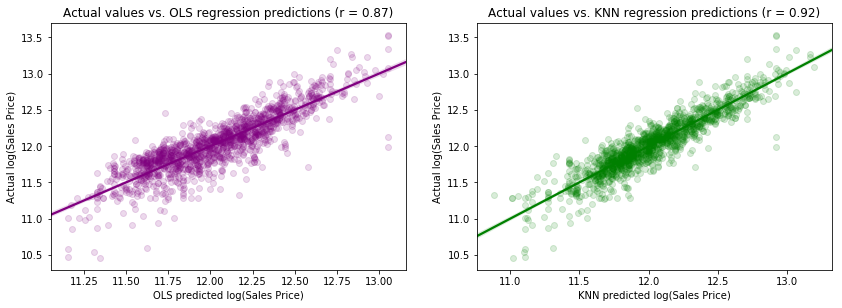

In [189]:
# Plot the charts
ols_r = round(regression_frame['ols_predictions'].corr(regression_frame[model_Y]),2)
knn_r = round(regression_frame['knn_predictions'].corr(regression_frame[model_Y]),2)

plt.figure(figsize=(14,10))

ax1 = plt.subplot(221)
sns.regplot(x='ols_predictions',
            y=model_Y, 
            data=regression_frame,
            color='Purple',
            scatter_kws={'alpha':0.15})

plt.title('Actual values vs. OLS regression predictions (r = {})'.format(ols_r))
ax1.set(xlabel='OLS predicted log(Sales Price)',
        ylabel='Actual log(Sales Price)')

ax2 = plt.subplot(222)
sns.regplot(x='knn_predictions', 
            y=model_Y, 
            data=regression_frame,
            color='Green',
            scatter_kws={'alpha':0.15})

plt.title('Actual values vs. KNN regression predictions (r = {})'.format(knn_r))
ax2.set(xlabel='KNN predicted log(Sales Price)',
        ylabel='Actual log(Sales Price)')

plt.show()

### _cross-validation_

In [191]:
# OLS cross validation
ols_cross_val = ols_cross_validation(features_df, 10, model_Y, model_X)
print('OLS cross-validation')
print('Mean R-squared across 10 folds: {}'.format(round(ols_cross_val['R2'].mean(),2)))
print('Variance: {}'.format(round(ols_cross_val['R2'].std()**2,4)))

# KNN cross validation
score = cross_val_score(knn_regr, X, Y, cv=10)

print('\nKNN cross-validation')
print('Mean accuracy across 10 folds: {}'.format(round(score.mean(),2)))
print('Variance: {}'.format(round(score.std()**2,4)))

OLS cross-validation
Mean R-squared across 10 folds: 0.75
Variance: 0.0009

KNN cross-validation
Mean accuracy across 10 folds: 0.71
Variance: 0.0012


## (d) Discussion

* Both models are predictive and are reasonably consistent across folds.


* The KNN model is slightly more correlated with actual values than the OLS model


* The OLS model is able to describe the relationships between individual features and sale price, but the KNN model is not. Any time I'm trying to drill down on individual features' influence on an outcome, OLS will be preferable to KNN.


* Although I used the same features for both models, more feature engineering was necessary for the OLS model than I think would have been if I'd just run the KNN. If I need something quick and dirty that works, I'll probably start with KNN.